<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Машинное обучение и майнинг данных"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: преподаватель Факультета Компьютерных Наук НИУ ВШЭ Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# Занятие 5. Продвинутые методы классификации и регрессии

### Практика.  Смешивание случайного леса и градиентного бустинга для набора данных по оттоку клиентов телеком-компании. Решение

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
import sys
sys.path.append('../../scripts/')
from log_progress import log_progress
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Считываем данные.**

In [2]:
df = pd.read_csv('../../data/telecom_churn.csv')

In [3]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
y = df['Churn']
df.drop(['State', 'Churn'], axis=1, inplace=True)

In [5]:
df['International plan'] = (df['International plan'] == 'Yes').astype('int')
df['Voice mail plan'] = (df['Voice mail plan'] == 'Yes').astype('int')

**Определим важность признаков с помощью случайного леса.**

In [6]:
rf = RandomForestClassifier(random_state=1).fit(df, y)

In [7]:
feaure_imp_df = pd.DataFrame(rf.feature_importances_,
             index=df.columns).sort([0], ascending=False)
feaure_imp_df

,0
Total day minutes,0.166285
Customer service calls,0.120678
Total day charge,0.105372
International plan,0.076782
Total eve charge,0.075501
Total eve minutes,0.065616
Total intl calls,0.059661
Total intl charge,0.046290
Total intl minutes,0.041530
Total night charge,0.040650


**Будем обучать лес на четных признаках, а Xgboost - на нечетных (в порядке убывания важности).**

In [8]:
rf_features = feaure_imp_df.index.tolist()[::2]
xgb_features = feaure_imp_df.index.tolist()[1::2]

**Отделим 30% данных, чтоб в конце проверять настроенные модели.**

In [9]:
X_train, X_holdout, y_train, y_holdout = \
                                train_test_split(df, y, test_size=0.3,
                                                 random_state=42)

### Кросс-валидация

In [10]:
def out_of_fold_prediction(clf, train_df, y_series, folds, scale=False):
    
    prediction = y_series.copy()
    for train_idx, test_idx in folds:
        X_train, X_test = train_df.iloc[train_idx, :], train_df.iloc[test_idx,:]
        y_train, y_test = y_series.iloc[train_idx], y_series.iloc[test_idx]
        
        if scale:
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        
        clf.fit(X_train, y_train)
        
        prediction.iloc[test_idx] = clf.predict_proba(X_test)[:, 1]
        
    return(prediction)

In [11]:
folds = StratifiedKFold(y_train, n_folds=5, random_state=42)

**Out-of-Fold-прогноз RF. Подбираем глубину деревьев.**

(0.73455255157758037, 14)
CPU times: user 24.8 s, sys: 2.15 s, total: 26.9 s
Wall time: 20.2 s


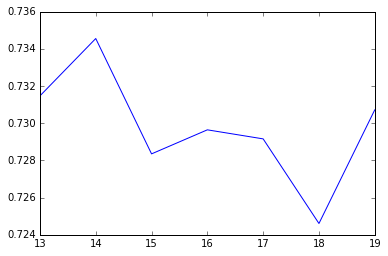

In [12]:
%%time
depths = range(13, 20)
scores = []

for depth in log_progress(depths):
    pred = out_of_fold_prediction(RandomForestClassifier(max_depth=depth,
                                                         n_estimators=100,
                                                        n_jobs=-1,
                                                        random_state=1),
                                 X_train[rf_features], y_train, folds)
    scores.append(roc_auc_score(y_train, pred))

plot(depths, scores)
print(max(scores), depths[np.argmax(scores)])

**У RandomForest на CV - 0.7346, на оставленной выборке - 0.7883.**

In [14]:
%%time
forest = RandomForestClassifier(max_depth=14, n_estimators=100, 
                                n_jobs=-1,
                                random_state=1)
forest.fit(X_train, y_train)
forest_oof_pred = out_of_fold_prediction(forest, 
                                         X_train[rf_features], y_train, folds)
forest_ho_pred = forest.predict_proba(X_holdout[rf_features])[:,1]
print('CV: {0}, Holdout: {1}'.format(round(roc_auc_score(y_train, 
                                                         forest_oof_pred), 4),
                                     round(roc_auc_score(y_holdout, 
                                                         forest_ho_pred), 4)))

CV: 0.7346, Holdout: 0.7883
CPU times: user 4.48 s, sys: 358 ms, total: 4.84 s
Wall time: 3.5 s


**Out-of-Fold-прогноз Xgboost. Подбираем глубину деревьев.**

(0.77617322393081678, 2)
CPU times: user 12.2 s, sys: 60.9 ms, total: 12.3 s
Wall time: 12.4 s


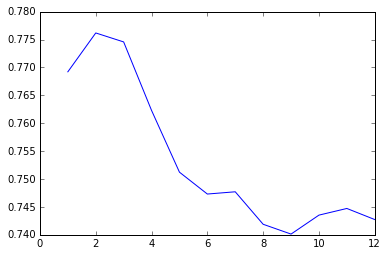

In [15]:
%%time

depths = range(1, 13)
scores = []

for depth in log_progress(depths):
    pred = out_of_fold_prediction(XGBClassifier(max_depth=depth,
                                               n_estimators=100),
                                 X_train[xgb_features], y_train, folds)
    scores.append(roc_auc_score(y_train, pred))

plot(depths, scores)
print(max(scores), depths[np.argmax(scores)])

**У Xgboost на CV - 0.7762, на оставленной выборке - 0.7707.**

In [17]:
%%time
xgb = XGBClassifier(max_depth=2, n_estimators=100)
xgb.fit(X_train, y_train)
xgb_oof_pred = out_of_fold_prediction(xgb,
                                 X_train[xgb_features], y_train, folds)
xgb_ho_pred = xgb.predict_proba(X_holdout[xgb_features])[:,1]
print('CV: {0}, Holdout: {1}'.format(round(roc_auc_score(y_train, 
                                                         xgb_oof_pred), 4),
                                     round(roc_auc_score(y_holdout, 
                                                         xgb_ho_pred), 4)))

CV: 0.7762, Holdout: 0.7707
CPU times: user 482 ms, sys: 2.46 ms, total: 484 ms
Wall time: 484 ms


### Смешивание Xgboost и RF

In [18]:
def best_linear_mix(target, pred1, pred2, metric=roc_auc_score):
    best_metric, best_w1 = 0, 0
    for w1 in np.linspace(0, 1, 20):
        curr_pred = (w1 * pred1 + (1 - w1) * pred2)
        curr_metric = metric(target, curr_pred)
        if curr_metric > best_metric:
            best_metric = curr_metric
            best_pred = curr_pred
            best_w1 = w1
    return best_metric, best_pred, best_w1

In [19]:
best_auc, best_pred, best_w1 = best_linear_mix(y_train, 
                                        xgb_oof_pred, forest_oof_pred)

In [21]:
round(best_auc, 4), round(best_w1, 2)

(0.8762, 0.58)

In [22]:
xgb_rf_ho_pred = best_w1 * xgb_ho_pred + (1 - best_w1) * forest_ho_pred

**У смеси на CV - 0.8762, на оставленной выборке - 0.9053.**

In [24]:
print(round(roc_auc_score(y_holdout, 
                          best_w1 * xgb_ho_pred + 
                          (1 - best_w1) * forest_ho_pred), 4))

0.9053


**Есть все основания полагать, что смесь Xgboost и RF сработала лучше, чем алгоритмы по отдельности.**

         _______________________________________
         |  ROC AUC    | Out-of-fold | Holdout |
         |_____________|_____________|_________|
         | XGBoost     | .7762       | .7707   |
         | RF          | .7346       | .7883   |
         | XGB + RF    | .8762       | .9053   |
         |_____________|_____________|_________|